# Import Libraries and Data

In [1]:
# data visualization
import lux 
import seaborn as sns
import missingno as msno

# modules
import pandas as pd
import numpy as np
import warnings
#from sklearn.base import BaseEstimator, TransformerMixin
#from sklearn.preprocessing import StandardScaler,RobustScaler
warnings.filterwarnings('ignore')

In [5]:
# Import data
print("Reading in data...")
tr_filepath = "J:\\java\\Python\\2020\\Airbnb\\train_users_2.csv"
df_train = pd.read_csv(tr_filepath, header=0, index_col=None)
te_filepath = "J:\\java\\Python\\2020\\Airbnb\\test_users.csv"
df_test = pd.read_csv(te_filepath, header=0, index_col=None)

# Combine into one dataset
df_all = pd.concat((df_train, df_test), axis=0, ignore_index=True)

Reading in data...


# Data Cleaning

In [7]:
df_all.head()

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [16]:
df_all.info()

<class 'lux.core.frame.LuxDataFrame'>
RangeIndex: 275547 entries, 0 to 275546
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   id                       275547 non-null  object        
 1   date_account_created     275547 non-null  datetime64[ns]
 2   timestamp_first_active   275547 non-null  datetime64[ns]
 3   gender                   275547 non-null  object        
 4   age                      158681 non-null  float64       
 5   signup_method            275547 non-null  object        
 6   signup_flow              275547 non-null  int64         
 7   language                 275547 non-null  object        
 8   affiliate_channel        275547 non-null  object        
 9   affiliate_provider       275547 non-null  object        
 10  first_affiliate_tracked  269462 non-null  object        
 11  signup_app               275547 non-null  object        
 12  first_device_typ

In [12]:
df_all['date_account_created'].dtype

dtype('O')

In [13]:
# Change Dates to consistent format
df_all['date_account_created'] = pd.to_datetime(df_all['date_account_created'], format='%Y-%m-%d')
df_all['timestamp_first_active'] = pd.to_datetime(df_all['timestamp_first_active'], format='%Y%m%d%H%M%S')
df_all['date_account_created'].fillna(df_all.timestamp_first_active, inplace=True)

Date_first_booking, we are going to drop (remove) from the training data altogether. The reason is that this field is only populated for users who have made a booking. For the data in training_users_2.csv, all the users that have a first booking country have a value in the date_first_booking column and for those that have not made a booking (country_destination = NDF) the value is missing. However, for the data in test_users.csv, the date_first_booking column is empty for all the records.

This means that this column is not going to be useful for predicting which country a booking will be made. What is more, if we leave it in the training dataset when building the model, it will likely increase the chances that the model predicts NDF as those are the records without dates in the training dataset.

In [15]:
# Remove date_first_booking column
df_all.drop('date_first_booking', axis=1, inplace=True)

In [72]:
class Preprocessor:
    
    def __init__(self, df):
        self.df = df.copy(deep=True)
    def missing_values(self):
        total = self.df.isnull().sum().sort_values(ascending=False)
        percent = (self.df.isnull().sum()/self.df.isnull().count()).sort_values(ascending=False)
        missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
        return missing_data.head(20)
    def msno_m(self):
        print(msno.bar(self.df));
        print(msno.matrix(self.df));
        print(msno.heatmap(self.df));
    def desc_data(self, features = None):
        if features == None:
            print(self.df.describe())
        else:
            for feat in features:
                print("--"*28)
                print(self.df[feat].describe())
    def remove_outliers(self, features, min_val, max_val):
        col_values = self.df[features].values
        self.df[features] = np.where(np.logical_or(col_values <= min_val, col_values >= max_val), np.NaN, col_values)
        return self.df

In [73]:
preprocessor = Preprocessor(df_all)

We need to analyze missing data and the ratio of it in the dataframe.

In [27]:
preprocessor.missing_values()

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In this step, we replace incorrect values with ‘NaN’, which literally stands for Not a Number, but implies we do not know the age value. In other words we are changing the incorrect values into missing values. To do this, we create a simple function that intakes a dataframe (table), a column name, a maximum acceptable value (90) and a minimum acceptable value (15). This function will then replace the values in the specified column that are outside the acceptable range with NaN.

There are also a significant number of users who did not provide their age at all – so they also show up as NaN in the dataset. After we have converted the incorrect age values to NaN, we then change all the NaN values to -1.

In [58]:
preprocessor.desc_data(["age","country_destination", "first_affiliate_tracked"])

--------------------------------------------------------
count    158681.000000
mean         47.145310
std         142.629468
min           1.000000
25%          28.000000
50%          33.000000
75%          42.000000
max        2014.000000
Name: age, dtype: float64
--------------------------------------------------------
count     213451
unique        12
top          NDF
freq      124543
Name: country_destination, dtype: object
--------------------------------------------------------
count        269462
unique            7
top       untracked
freq         143181
Name: first_affiliate_tracked, dtype: object


As we can see from the nullity matrix, age and the other missing columns don't have a nullity correlation. This means, missing values in the age columns are either totally random or due to structural reasons.

In [75]:
df_all = preprocessor.remove_outliers(features='age', min_val=15, max_val=90)
df_all['age'].fillna(-1, inplace=True)

In [76]:
df_all['age'].isnull().sum()

0

In [77]:
df_all['age'].describe()

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

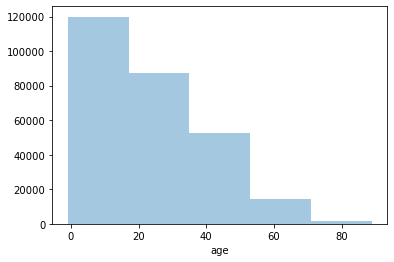

In [78]:
sns.distplot(df_all.age,bins = 5, kde = False);

AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.698618x0.755)
AxesSubplot(0.125,0.125;0.62x0.755)


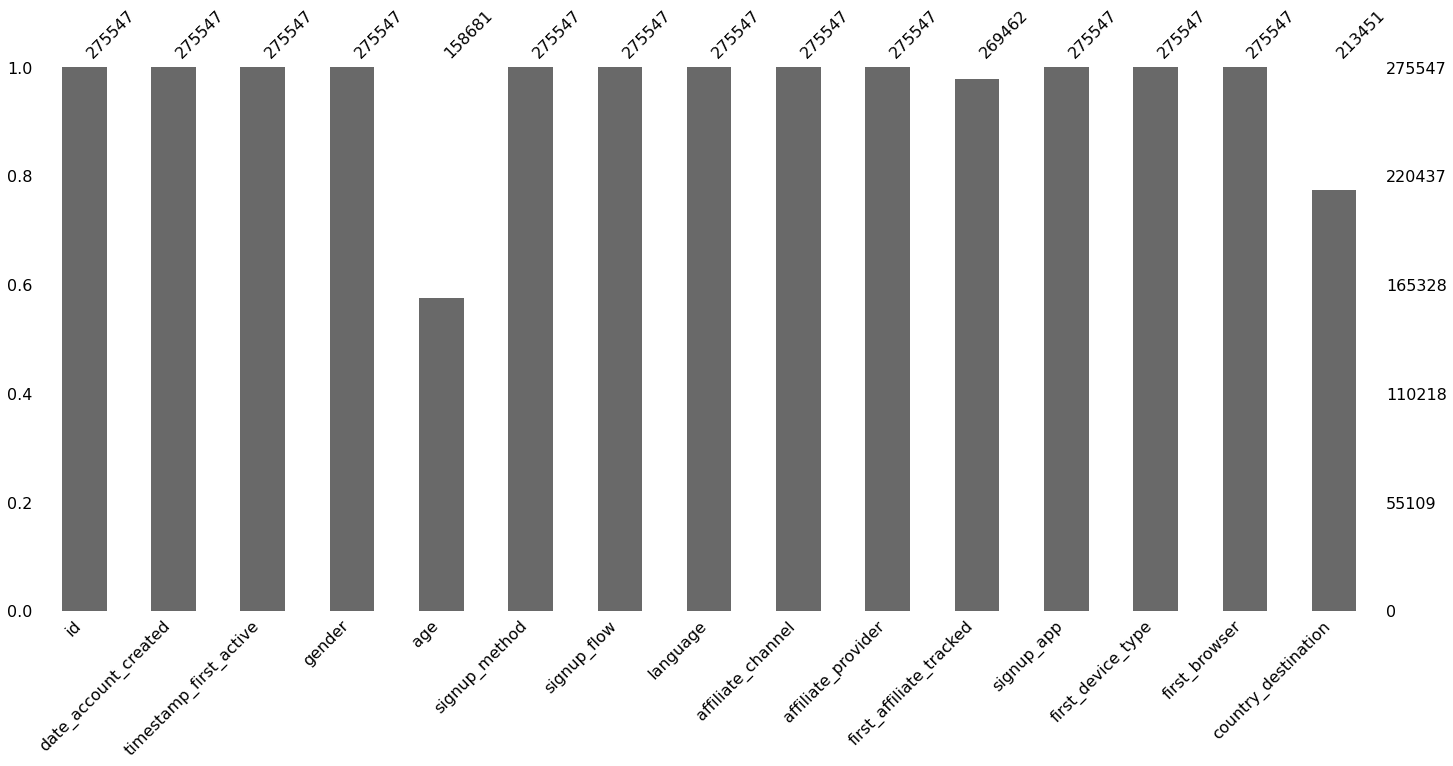

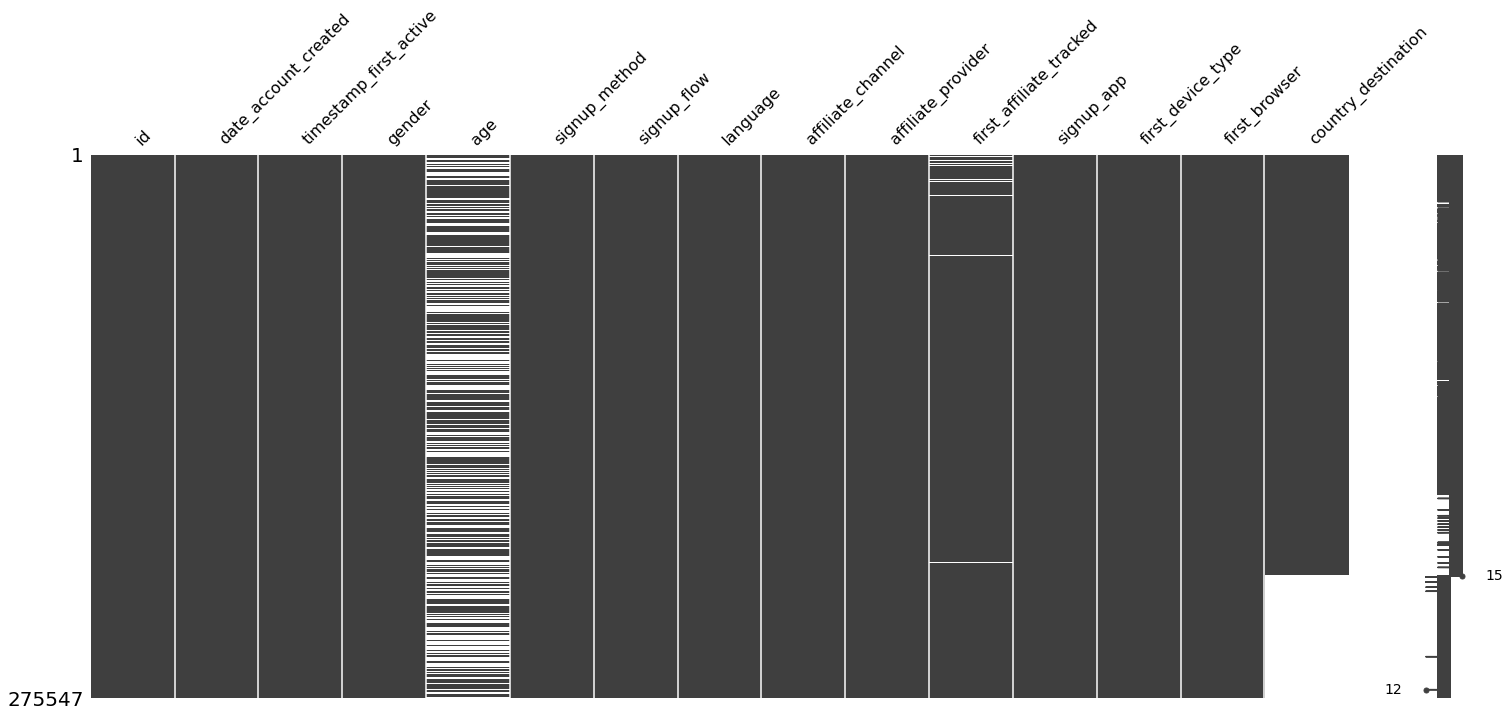

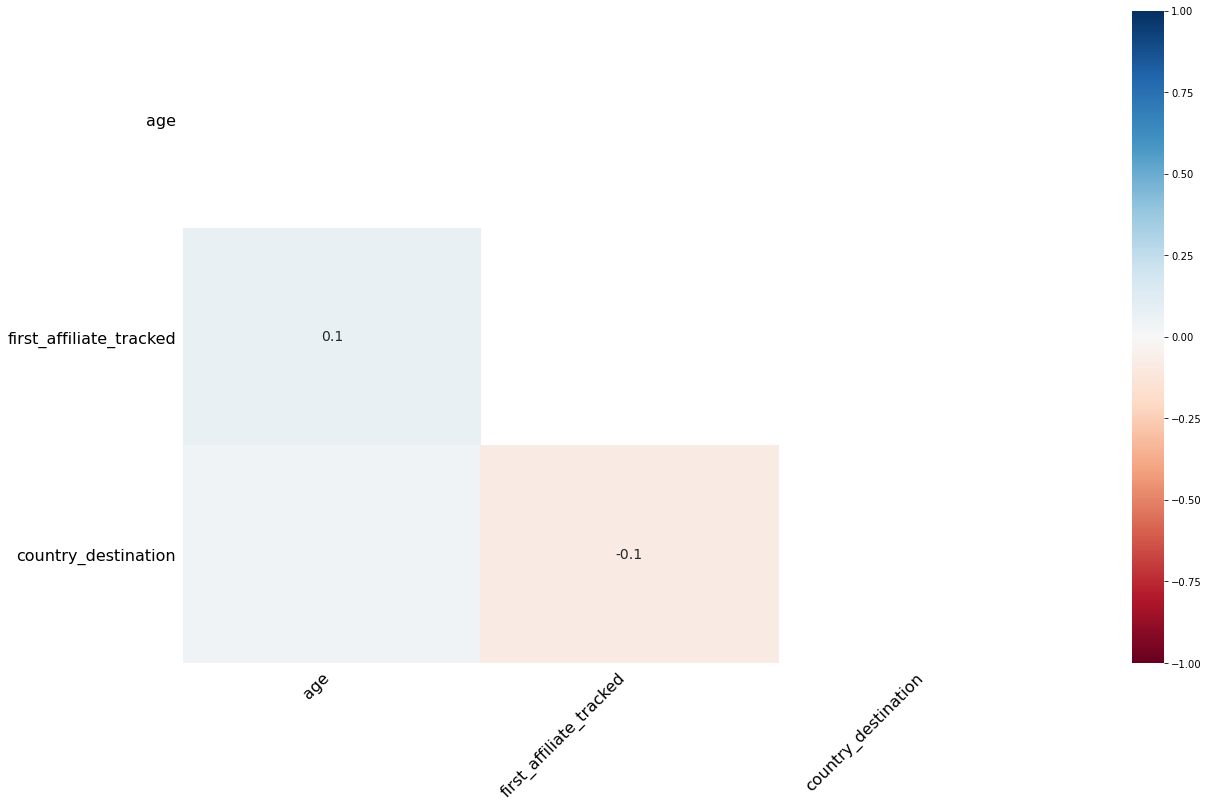

In [30]:
preprocessor.msno_m()

We replace missing values of categorical features with the mode value of that feature.

In [83]:
df_all["country_destination"].fillna(df_all["country_destination"].mode()[0], inplace=True)
df_all["first_affiliate_tracked"].fillna(df_all["first_affiliate_tracked"].mode()[0], inplace=True)

In [84]:
df_all.isnull().sum()

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

# Scale and Normalize

In [3]:
# for Box-Cox Transformation
from scipy import stats

# for min_max scaling
from sklearn import preprocessing

# plotting modules
import matplotlib.pyplot as plt

# read in all our data
kickstarters_2017 = pd.read_csv("J:\\java\\Python\\2020\\PortfolioProject\\Kickstarter\\ks-projects-201801.csv")

# set seed for reproducibility
np.random.seed(0)

In [13]:
kickstarters_2017.head()

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [14]:
kickstarters_2017.info()

<class 'lux.core.frame.LuxDataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   ID                378661 non-null  int64  
 1   name              378657 non-null  object 
 2   category          378661 non-null  object 
 3   main_category     378661 non-null  object 
 4   currency          378661 non-null  object 
 5   deadline          378661 non-null  object 
 6   goal              378661 non-null  float64
 7   launched          378661 non-null  object 
 8   pledged           378661 non-null  float64
 9   state             378661 non-null  object 
 10  backers           378661 non-null  int64  
 11  country           378661 non-null  object 
 12  usd pledged       374864 non-null  float64
 13  usd_pledged_real  378661 non-null  float64
 14  usd_goal_real     378661 non-null  float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB


## Scale Data

This means that you're transforming your data so that it fits within a specific scale, like 0-100 or 0-1. 

For example, you might be looking at the prices of some products in both Yen and US Dollars. One US Dollar is worth about 100 Yen, but if you don't scale your prices methods like SVM or KNN will consider a difference in price of 1 Yen as important as a difference of 1 US Dollar! This clearly doesn't fit with our intuitions of the world. With currency, you can convert between currencies. But what about if you're looking at something like height and weight? It's not entirely clear how many pounds should equal one inch (or how many kilograms should equal one meter).

By scaling your variables, you can help compare different variables on equal footing. To help solidify what scaling looks like, let's look at a made-up example. (Don't worry, we'll work with real data in just a second, this is just to help illustrate my point.)

Text(0.5, 1.0, 'Scaled data')

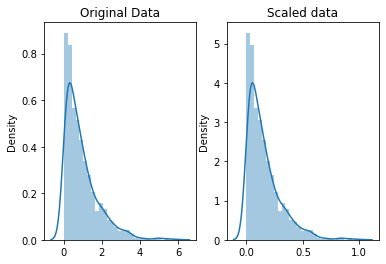

In [9]:
# generate 1000 data points randomly drawn from an exponential distribution
original_data = np.random.exponential(size = 1000)

# mix-max scale the data between 0 and 1
scaled_data = preprocessing.minmax_scale(original_data)

# plot both together to compare
fig, ax=plt.subplots(1,2)
sns.distplot(original_data, ax=ax[0])
ax[0].set_title("Original Data")
sns.distplot(scaled_data, ax=ax[1])
ax[1].set_title("Scaled data")

Notice that the shape of the data doesn't change, but that instead of ranging from 0 to 8ish, it now ranges from 0 to 1.

Text(0.5, 1.0, 'Scaled data')

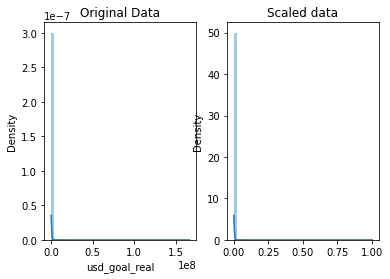

In [12]:
# select the usd_goal_real column
usd_goal = kickstarters_2017.usd_goal_real

# scale the goals from 0 to 1
scaled_data = preprocessing.minmax_scale(usd_goal)

# plot the original & scaled data together to compare
fig, ax=plt.subplots(1,2)
sns.distplot(kickstarters_2017.usd_goal_real, ax=ax[0])
ax[0].set_title("Original Data")
sns.distplot(scaled_data, ax=ax[1])
ax[1].set_title("Scaled data")

Text(0.5, 1.0, 'Scaled data')

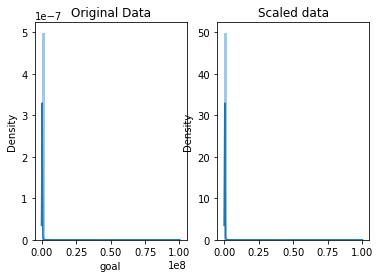

In [15]:
goal = kickstarters_2017.goal

# scale the goals from 0 to 1
scaled_data = preprocessing.minmax_scale(goal)

# plot the original & scaled data together to compare
fig, ax=plt.subplots(1,2)
sns.distplot(kickstarters_2017.goal, ax=ax[0])
ax[0].set_title("Original Data")
sns.distplot(scaled_data, ax=ax[1])
ax[1].set_title("Scaled data")

## Normalization

Scaling just changes the range of your data. Normalization is a more radical transformation. The point of normalization is to change your observations so that they can be described as a normal distribution.

In general, you'll only want to normalize your data if you're going to be using a machine learning or statistics technique that assumes your data is normally distributed. Some examples of these include t-tests, ANOVAs, linear regression, linear discriminant analysis (LDA) and Gaussian naive Bayes. (Pro tip: any method with "Gaussian" in the name probably assumes normality.)

Text(0.5, 1.0, 'Normalized data')

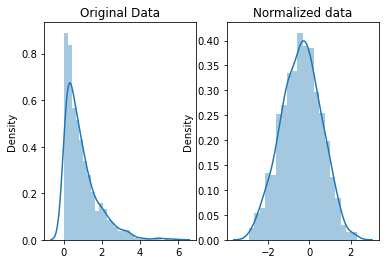

In [10]:
# normalize the exponential data with boxcox
normalized_data = stats.boxcox(original_data)

# plot both together to compare
fig, ax=plt.subplots(1,2)
sns.distplot(original_data, ax=ax[0])
ax[0].set_title("Original Data")
sns.distplot(normalized_data[0], ax=ax[1])
ax[1].set_title("Normalized data")

Text(0.5, 1.0, 'Normalized data')

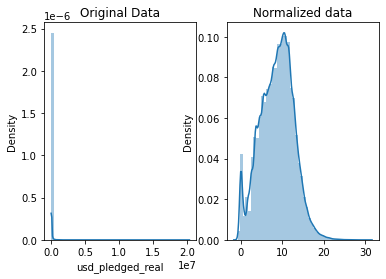

In [16]:
# get the index of all positive pledges (Box-Cox only takes postive values)
index_of_positive_pledges = kickstarters_2017.usd_pledged_real > 0

# get only positive pledges (using their indexes)
positive_pledges = kickstarters_2017.usd_pledged_real.loc[index_of_positive_pledges]

# normalize the pledges (w/ Box-Cox)
normalized_pledges = stats.boxcox(positive_pledges)[0]

# plot both together to compare
fig, ax=plt.subplots(1,2)
sns.distplot(positive_pledges, ax=ax[0])
ax[0].set_title("Original Data")
sns.distplot(normalized_pledges, ax=ax[1])
ax[1].set_title("Normalized data")

# Multivariate Outlier Analysis

Local Outlier Factor

Local Outlier Factor (LOF) is a score that tells how likely a certain data point is an outlier/anomaly.

It allows us to define values that may be outliers by scoring the observations based on the density at their location.

The local density of a point is compared with its neighbors. If a point is significantly lower than the density of its neighbors, it can be interpreted that this point is in a less frequent area than its neighbors. Therefore, there is a neighborhood structure here. If the perimeter of a value is not dense, then this value is considered as an outlier.

In [17]:
diamonds = sns.load_dataset('diamonds')
diamonds = diamonds.select_dtypes(include = ['float64', 'int64']) 
df = diamonds.copy()
df = df.dropna()
df.head()

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [18]:
from sklearn.neighbors import LocalOutlierFactor

In [19]:
clf = LocalOutlierFactor(n_neighbors = 20, contamination = 0.1) # When determining the outlier, the general acceptance in practice is that the outlier density should not be more than 10% of the data set (Contamination= density). That's why we chose 0.1.

In [20]:
clf.fit_predict(df)

array([-1, -1, -1, ...,  1,  1,  1])

In [21]:
df_scores = clf.negative_outlier_factor_

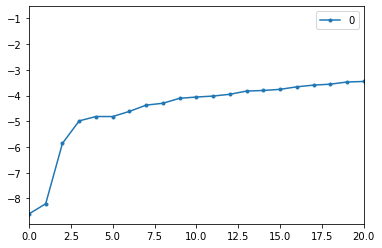

In [22]:
pd.DataFrame(np.sort(df_scores)).plot(stacked = True, xlim =[0,20], style=".-");
#sıçrama yapan yer 3.sıra orayı alcan

In [23]:
threshold = np.sort(df_scores)[2]

In [24]:
outlier_tf = df_scores < threshold

Removing outliers

In [25]:
new_df  = df[df_scores > threshold]

Suppresion

In [28]:
suppressed_values = df[df_scores == threshold]

In [27]:
outliers = df[outlier_tf]

In [30]:
res = outliers.to_records(index = False)

In [31]:
res[:] = suppressed_values.to_records(index = False)

In [32]:
res

rec.array([(1.03, 78.2, 54., 1262, 5.72, 5.59, 4.42),
           (1.03, 78.2, 54., 1262, 5.72, 5.59, 4.42)],
          dtype=[('carat', '<f8'), ('depth', '<f8'), ('table', '<f8'), ('price', '<i8'), ('x', '<f8'), ('y', '<f8'), ('z', '<f8')])

In [33]:
df[outlier_tf] = pd.DataFrame(res, index = df[outlier_tf].index)

In [34]:
df[outlier_tf]

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()